# Problem Setup

In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
from matplotlib import pyplot as plt
import os, glob

In [5]:
def import_data():
    files = glob.glob("data/*.csv")
    prices = pd.DataFrame({ os.path.basename(file).split(".")[0] : pd.read_csv(file, index_col="Date", date_format="%m/%Y")["Close"] for file in files })
    return prices, len(files)

prices, num_stocks = import_data()
returns = prices.pct_change().dropna()

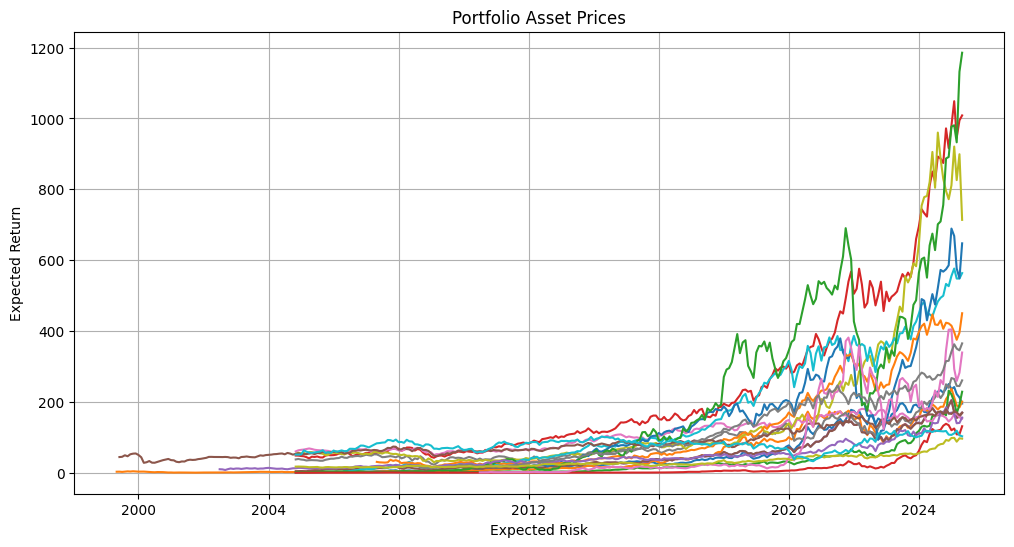

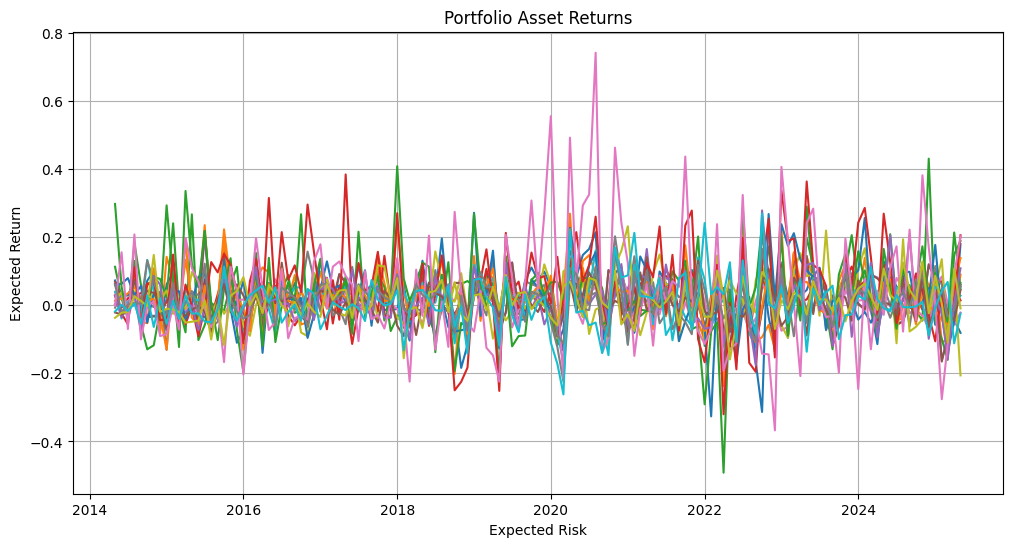

In [6]:
# Plot Asset Prices
plt.figure(figsize=(12, 6))
plt.plot(prices)
plt.grid(True)
plt.ylabel("Expected Return")
plt.xlabel("Expected Risk")
plt.title("Portfolio Asset Prices")
plt.show()

# Plot Asset Returns
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.grid(True)
plt.ylabel("Expected Return")
plt.xlabel("Expected Risk")
plt.title("Portfolio Asset Returns")
plt.show()

In [7]:
mu_hat = np.reshape(returns.mean().values, (num_stocks, 1)) # Vector of expected return for each asset
Sigma_hat = returns.cov().values # Covariance matrix for asset returns

In [8]:
class Model:
    def __init__(self, mu, Sigma):
        self.mu = mu
        self.Sigma = Sigma

        self.x_vec = []
        self.objective_values = []
        
    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.objective_values, self.r_range)
        plt.grid(True)
        plt.ylabel("Expected Return")
        plt.xlabel("Expected Risk")

# Vanilla Model Allowing Shorting

In [21]:
class shortModel(Model):
    def __init__(self, mu, Sigma):
        super().__init__(mu, Sigma)
        
        self.r_range = [0.001*i for i in range(101)]

    def solve(self):
        row1 = np.hstack( (2*self.Sigma, self.mu, np.ones((num_stocks, 1))) )
        row2 = np.hstack( (self.mu.T, np.zeros((1, 2))) )
        row3 = np.hstack( (np.ones((num_stocks, 1)).T, np.zeros((1, 2))) )
        L_mat = np.vstack( (row1, row2, row3) ) # Lagrangian matrix - num_stock+2 x num_stocks+2 dimensional matrix; we will need to take the inverse

        for r in self.r_range: 
            x_lambda = np.linalg.inv(L_mat) @ np.vstack( (np.zeros((num_stocks, 1)), [[r]], [[1]]) )
            x = np.array([x_lambda[i].item() for i in range(num_stocks)])
            var = x.T @ ( self.Sigma @ x )
            self.x_vec.append(x)
            self.objective_values.append(var)

    def plot(self):
        super().plot()
        plt.title("Efficient Frontier for Vanilla Model (with shorting)")
        plt.show()

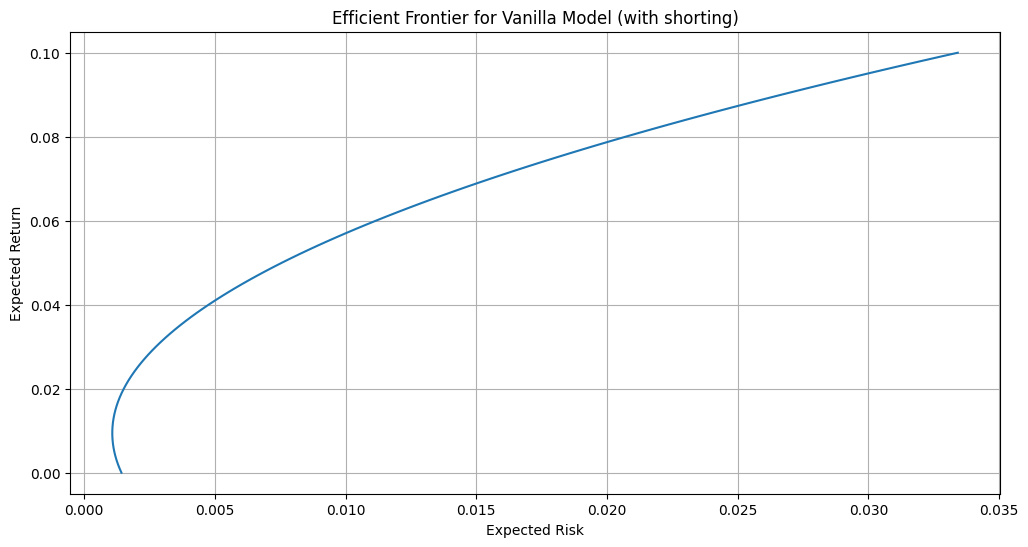

In [22]:
Short = shortModel(mu_hat, Sigma_hat)
Short.solve()
Short.plot()

# Vanilla Model without Shorting

In [21]:
min(mu_hat), max(mu_hat)

(array([0.00287612]), array([0.05175276]))

In [34]:
class noShortModel(Model):
    def __init__(self, mu, Sigma):
        super().__init__(mu, Sigma)

        self.mu_range = (min(self.mu), max(self.mu))
        self.r_range = np.linspace(self.mu_range[0]+1e-3, self.mu_range[1], 50)

        self.x = cp.Variable(num_stocks)
        self.f = cp.quad_form(self.x, self.Sigma)

    def g(self, r):
        return [ self.mu.T @ self.x == r, sum(self.x) == 1, self.x >= 0]

    def solve(self):
        for r in self.r_range:
            prob = cp.Problem(cp.Minimize(self.f), self.g(r))
            prob.solve()
            if prob.status == "optimal":
                self.x_vec.append(self.x.value)
                self.objective_values.append(self.x.value @ (self.Sigma @ self.x.value))
            else:
                print(f"Problem {prob.status} for {r=}")

    def plot(self):
        super().plot()
        plt.title("Efficient Frontier for Vanilla Model (no shorting)")
        plt.show()

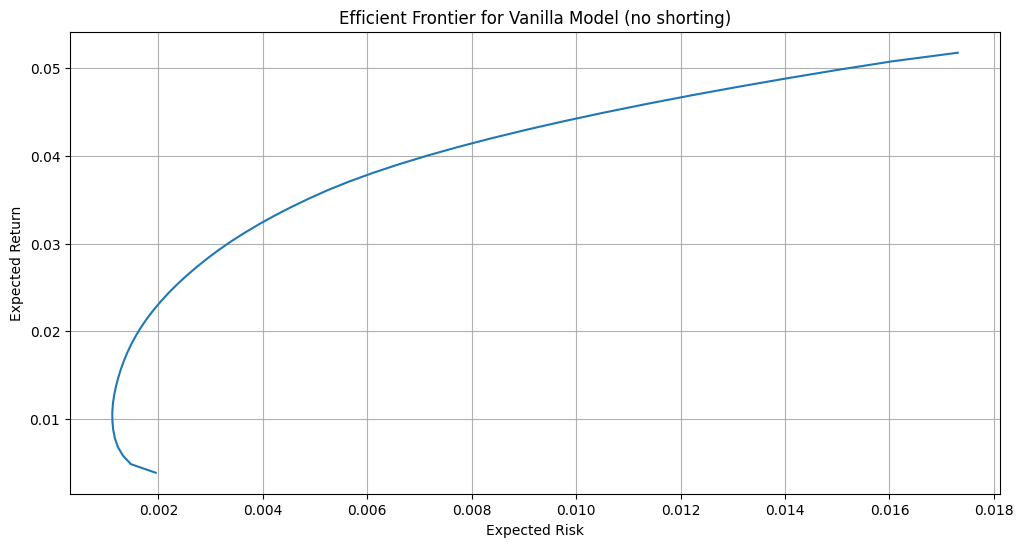

In [35]:
noShort = noShortModel(mu_hat, Sigma_hat)
noShort.solve()
noShort.plot()

# Comparision of Models with and without Shorting

In [10]:
# Compare Efficient Frontiers of short and no short models
def compare_plots(models, names, title):
    plt.figure(figsize=(12, 6))
    for i in range(len(models)):
        plt.plot(models[i].objective_values, models[i].r_range, label=names[i])
    plt.grid(True)
    plt.ylabel("Expected Return")
    plt.xlabel("Expected Risk")
    plt.title(title)
    plt.legend()
    plt.show()

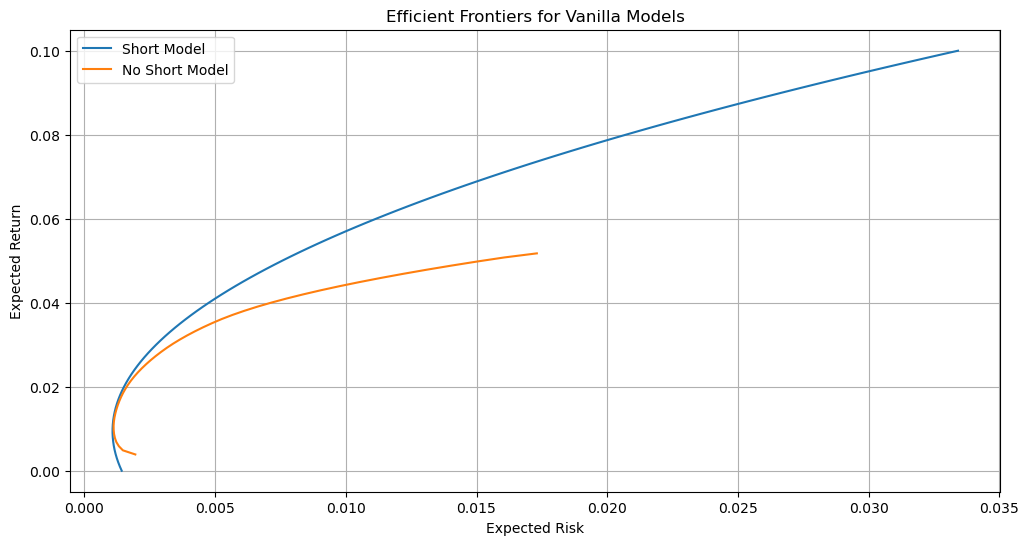

In [11]:
compare_plots(
    (Short, noShort), 
    ("Short Model", "No Short Model"), 
    "Efficient Frontiers for Vanilla Models")

As a note, we will stick with the no shorting model for ease of this particular project. 

# Risk-Free Asset Model

In [12]:
class riskFreeAssetModel(noShortModel):
    def __init__(self, mu, Sigma):
        super().__init__(mu, Sigma)

        self.x_cash = cp.Variable()
        self.rf = 0.001

    def g(self, r):
        return [ self.mu.T @ self.x + self.rf * self.x_cash == r, sum(self.x) + self.x_cash == 1, self.x >= 0, self.x_cash >= 0]

    def plot(self):
        super(noShortModel, self).plot()
        plt.title("Risk-Free Asset Model")
        plt.show()

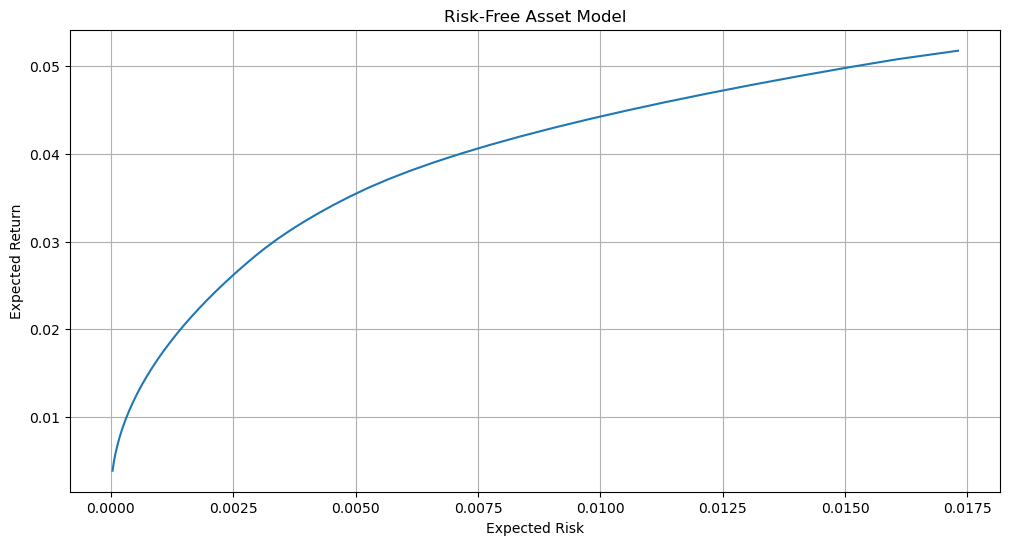

In [13]:
riskFreeAsset = riskFreeAssetModel(mu_hat, Sigma_hat)
riskFreeAsset.solve()
riskFreeAsset.plot()

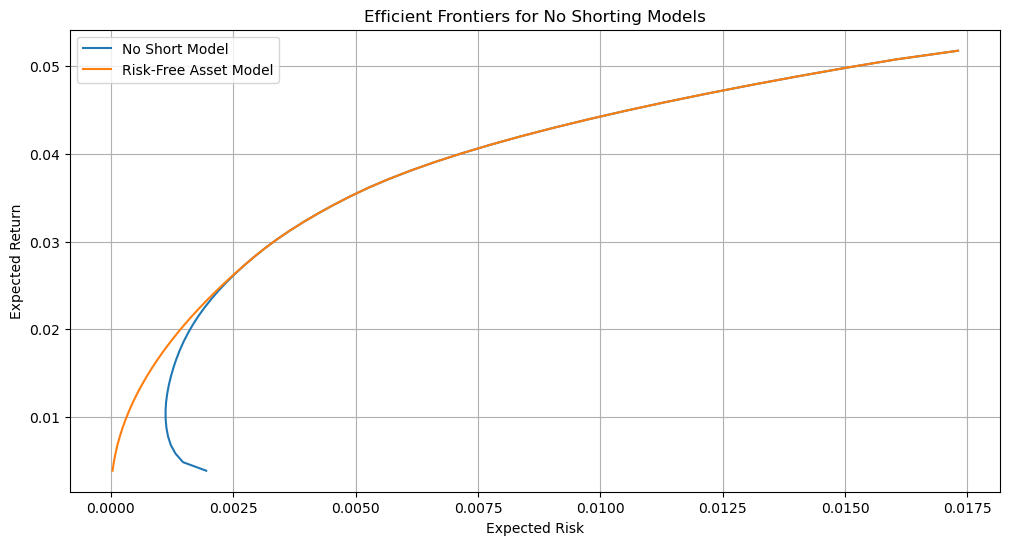

In [14]:
compare_plots(
    (noShort, riskFreeAsset), 
    ("No Short Model", "Risk-Free Asset Model"),
    "Efficient Frontiers for No Shorting Models")

# Adding an $L^1$ (Sparsity) Penalty

In [17]:
class L1Model(riskFreeAssetModel):
    def __init__(self, mu, Sigma, gamma):
        super().__init__(mu, Sigma)

        self.f = self.f + gamma * cp.norm1(self.x)

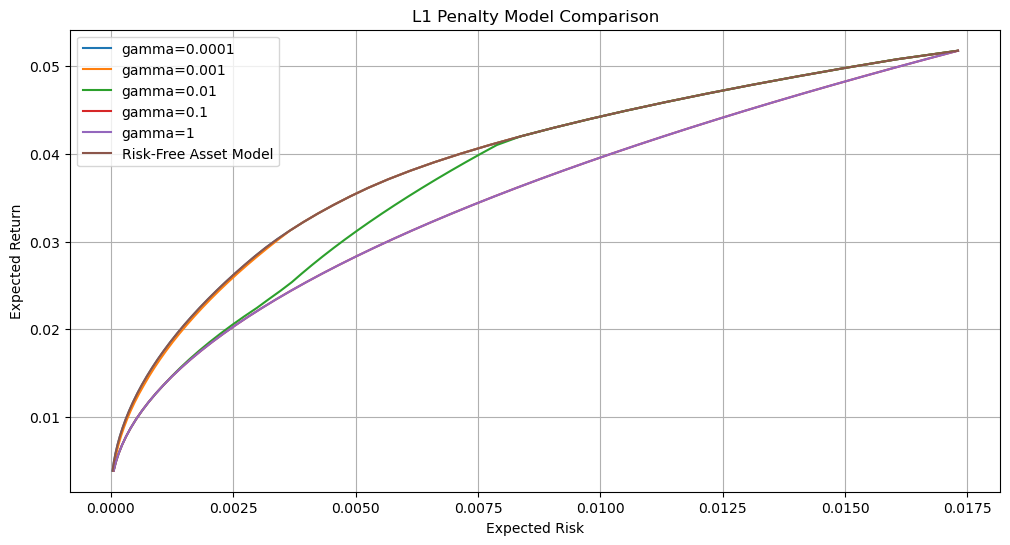

In [18]:
models = []
gammas = [0.0001, 0.001, 0.01, 0.1, 1]
for gamma in gammas:
    L1 = L1Model(mu_hat, Sigma_hat, gamma)
    L1.solve()
    models.append(L1)

models.append(riskFreeAsset)
names = [f"{gamma=}" for gamma in gammas]
names.append("Risk-Free Asset Model")

compare_plots(
    models, 
    names, 
    "L1 Penalty Model Comparison")

# Adding an $L^2$ (Sensitivity) Penalty

In [19]:
class L2Model(riskFreeAssetModel):
    def __init__(self, mu, Sigma, gamma):
        super().__init__(mu, Sigma)

        self.f = self.f + gamma * cp.sum_squares(self.x)

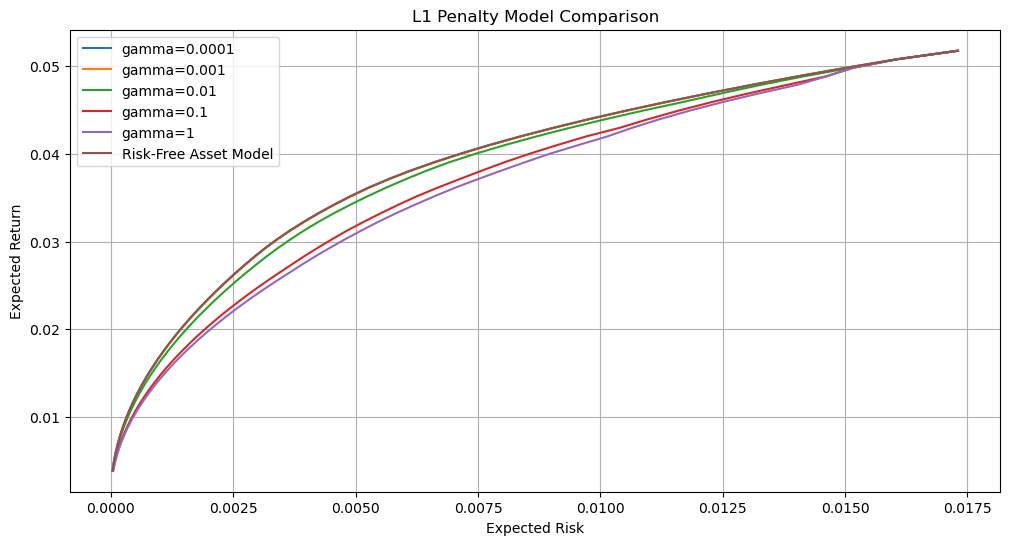

In [20]:
models = []
gammas = [0.0001, 0.001, 0.01, 0.1, 1]
for gamma in gammas:
    L2 = L2Model(mu_hat, Sigma_hat, gamma)
    L2.solve()
    models.append(L2)
    
models.append(riskFreeAsset)
names = [f"{gamma=}" for gamma in gammas] 
names.append("Risk-Free Asset Model")

compare_plots(
    models, 
    names,
    "L1 Penalty Model Comparison")

Note: We keep the original risk-free asset model after comparing with L1 and L2 penalty models. 